## Imports

In [202]:

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib

from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Global Values

In [203]:
NUMBER_TORNADOS = 111 #Number of Tornado Events
NUMBER_RANDOM = 110 #Number of Random Events
NUMBER_DAYS = 14 #Number of days of data per Tornado/Event (Max: 57)
FILE_NAME = "all_data.csv" #CSV file that contains the data

## Loading Data

In [125]:

#Field 0: 'datatime'
#Field 1: 'temperature'
#Field 2: 'windspeed'
#Field 3: 'surface solar radiation' -Alvaro
#Field 4: 'relative humidity' -Abdullah
#Field 5: 'surface pressure' -Frazier
#Field 6: 'total precipitation' -Simon
#Field 7: 'city'
#Field 8: 'event_id'
#Field 9: 'latitude'
#Field 10: 'longitude'
#Field 11: 'outcome'

data = pd.read_csv (FILE_NAME)
df = data.drop(columns=['Unnamed: 0'])
event_ids = set(df['event_id'].to_numpy())

## Create Timeserie Fetaures

### Two Week Out Prediction

In [332]:
# Determine slope of each weather attribute over time for each Tornado/Event
temp_change = []
wind_change = []
rain_change = []
radiation_change = []
pressure_change = []
humidity_change = []
x = list(range(NUMBER_DAYS))

for i in event_ids:
    event = df.loc[df['event_id'] == i]
    temp = event['temperature']
    wind = event['wind_speed']
    radiation = event['surface_solar_radiation']
    humidity = event['relative_humidity']
    pressure = event['surface_pressure']
    rain = event['total_precipitation']

    t_slope, intercept, r_value, p_value, std_err = stats.linregress(x, temp[-28:-14])
    w_slope, intercept, r_value, p_value, std_err = stats.linregress(x, wind[-28:-14])
    r_slope, intercept, r_value, p_value, std_err = stats.linregress(x, rain[-28:-14])
    rd_slope, intercept, r_value, p_value, std_err = stats.linregress(x, radiation[-28:-14])
    p_slope, intercept, r_value, p_value, std_err = stats.linregress(x, pressure[-28:-14])
    h_slope, intercept, r_value, p_value, std_err = stats.linregress(x, humidity[-28:-14])

    temp_change.append(t_slope)
    wind_change.append(w_slope)
    rain_change.append(r_slope)
    radiation_change.append(rd_slope)
    pressure_change.append(p_slope)
    humidity_change.append(h_slope)


## Dataframe with mean values of each Tornado/Event

In [333]:
t1 = df.groupby('event_id').tail(28)
t2 = t1.groupby('event_id').head(14)
# cond = t1.index.isin(t2.index)
# t1.drop(t1[cond].index, inplace = True)
averages_two = t2.groupby('event_id').mean()


## Add Slope Features

In [334]:
averages_two['t_slope'] = temp_change
averages_two['w_slope'] = wind_change
averages_two['r_slope'] = rain_change
averages_two['rd_slope'] = radiation_change
averages_two['p_slope'] = pressure_change
averages_two['h_slope'] = humidity_change

In [207]:
averages_two.groupby("outcome").count()

,temperature,wind_speed,surface_solar_radiation,relative_humidity,surface_pressure,total_precipitation,latitude,longitude,t_slope,w_slope,r_slope,rd_slope,p_slope,h_slope
outcome,,,,,,,,,,,,,,
0.0,198,198,198,198,198,198,0,0,198,198,198,198,198,198
1.0,407,407,407,407,407,407,407,407,407,407,407,407,407,407


## Model Prep

In [335]:
X_two = averages_two[['temperature','wind_speed','surface_solar_radiation', 'total_precipitation', 't_slope', 'w_slope', 'r_slope', 'rd_slope', 'h_slope']]
y_two = averages_two['outcome']
x_train2, x_test2, y_train2, y_test2 = train_test_split(X_two, y_two, test_size=0.2, random_state=0)

## Train Model with Logistic Regression

In [336]:
# logisticRegr2 = LogisticRegression(max_iter=10000)
# logisticRegr2.fit(x_train2, y_train2)
# predictions2 = logisticRegr2.predict(x_test2)
# score2 = logisticRegr2.score(x_test2, y_test2)
# print("Model Accuracy Two Week Prediction: ",score2)
scaler_two = StandardScaler()

normalized_x_train_two = pd.DataFrame(scaler_two.fit_transform(x_train2), columns = x_train2.columns)
logisticRegr2 = LogisticRegression(C=0.01, solver='liblinear').fit(normalized_x_train_two, y_train2)

normalized_x_test_two = pd.DataFrame(scaler_two.transform(x_test2), columns = x_test2.columns)
y_test_pred_two = logisticRegr2.predict(normalized_x_test_two)
score2 = logisticRegr2.score(normalized_x_test_two, y_test2)
print("Model Accuracy Two Week Prediction: ",score2)

Model Accuracy Two Week Prediction:  0.8351648351648352


In [337]:
print("regression coefficients: \n", logisticRegr2.coef_)


regression coefficients: 
 [[-0.00904393 -0.11194944  0.26875211  0.19724227  0.16133168  0.01127687
  -0.03892095  0.16805473  0.12349351]]


## Determine Individual Feature Strength

In [134]:
# Returns array with model accuracy based on individial feature
# scores = []
# for i in range(11):

#     logisticRegr = LogisticRegression()
#     logisticRegr.fit(x_train2.to_numpy()[:,i].reshape(-1,1), y_train2)
#     score = logisticRegr.score(x_test2.to_numpy()[:,i].reshape(-1,1), y_test2)
#     scores.append(round(score,2))
# print(scores)

[0.71, 0.7, 0.8, 0.71, 0.71, 0.7, 0.71, 0.71, 0.69, 0.71, 0.71]


## Train Model with Naive Bayes

In [338]:
gnb = GaussianNB()
gnb.fit(normalized_x_train_two, y_train2)
predictions = gnb.predict(normalized_x_test_two)
score = gnb.score(normalized_x_test_two, y_test2)
print("Model Accuracy Two Week Prediction: ",score)

Model Accuracy Two Week Prediction:  0.8131868131868132


In [339]:
X_2 = pd.DataFrame(scaler_two.transform(X_two), columns = X_two.columns)
two_pred_all = logisticRegr2.predict(X_2)

### Model For Prediction One Week Out

In [340]:
# Determine slope of each weather attribute over time for each Tornado/Event
temp_change = []
wind_change = []
rain_change = []
radiation_change = []
pressure_change = []
humidity_change = []
x = list(range(NUMBER_DAYS+7))

for i in event_ids:
    event = df.loc[df['event_id'] == i]
    temp = event['temperature']
    wind = event['wind_speed']
    radiation = event['surface_solar_radiation']
    humidity = event['relative_humidity']
    pressure = event['surface_pressure']
    rain = event['total_precipitation']
    t_slope, intercept, r_value, p_value, std_err = stats.linregress(x, temp[-28:-7])
    w_slope, intercept, r_value, p_value, std_err = stats.linregress(x, wind[-28:-7])
    r_slope, intercept, r_value, p_value, std_err = stats.linregress(x, rain[-28:-7])
    rd_slope, intercept, r_value, p_value, std_err = stats.linregress(x, radiation[-28:-7])
    p_slope, intercept, r_value, p_value, std_err = stats.linregress(x, pressure[-28:-7])
    h_slope, intercept, r_value, p_value, std_err = stats.linregress(x, humidity[-28:-7])

    temp_change.append(t_slope)
    wind_change.append(w_slope)
    rain_change.append(r_slope)
    radiation_change.append(rd_slope)
    pressure_change.append(p_slope)
    humidity_change.append(h_slope)

In [341]:
t1 = df.groupby('event_id').tail(28)
t2 = t1.groupby('event_id').head(21)
# cond = t1.index.isin(t2.index)
# t1.drop(t1[cond].index, inplace = True)
averages_one = t2.groupby('event_id').mean()

In [342]:
averages_one['t_slope'] = temp_change
averages_one['w_slope'] = wind_change
averages_one['r_slope'] = rain_change
averages_one['rd_slope'] = radiation_change
averages_one['p_slope'] = pressure_change
averages_one['h_slope'] = humidity_change
averages_one['two_week_pred'] = two_pred_all

In [343]:
X_one = averages_one[['temperature','wind_speed','surface_solar_radiation', 'total_precipitation', 't_slope', 'w_slope', 'r_slope', 'rd_slope', 'h_slope', 'two_week_pred']]
y_one = averages_one['outcome']
x_train1, x_test1, y_train1, y_test1 = train_test_split(X_one, y_one, test_size=0.2, random_state=0)

In [344]:
# logisticRegr1 = LogisticRegression(max_iter=10000)
# logisticRegr1.fit(x_train1, y_train1)
# predictions1 = logisticRegr1.predict(x_test1)
# score1 = logisticRegr1.score(x_test1, y_test1)
# print("Model Accuracy Two Week Prediction: ",score1)

scaler_one = StandardScaler()

normalized_x_train_one = pd.DataFrame(scaler_one.fit_transform(x_train1), columns = x_train1.columns)
logisticRegr1 = LogisticRegression(C=0.01, solver='liblinear').fit(normalized_x_train_one, y_train1)

normalized_x_test_one = pd.DataFrame(scaler_one.transform(x_test1), columns = x_test1.columns)
y_test_pred_one = logisticRegr1.predict(normalized_x_test_one)
score1 = logisticRegr1.score(normalized_x_test_one, y_test1)
print("Model Accuracy One Week Prediction: ",score1)

Model Accuracy Two Week Prediction:  0.8351648351648352


In [345]:
gnb = GaussianNB()
gnb.fit(normalized_x_train_one, y_train1)
predictions = gnb.predict(normalized_x_test_one)
score = gnb.score(normalized_x_test_one, y_test1)
print("Model Accuracy One Week Prediction: ",score)

Model Accuracy Two Week Prediction:  0.8571428571428571


In [346]:
X_1 = pd.DataFrame(scaler_one.transform(X_one), columns = X_one.columns)
one_pred_all = logisticRegr1.predict(X_1)
one_pred_all2 = gnb.predict(X_1)


### Model For Prediction Three Days Out

In [347]:
# Determine slope of each weather attribute over time for each Tornado/Event
temp_change = []
wind_change = []
rain_change = []
radiation_change = []
pressure_change = []
humidity_change = []
x = list(range(11))

for i in event_ids:
    event = df.loc[df['event_id'] == i]
    temp = event['temperature']
    wind = event['wind_speed']
    radiation = event['surface_solar_radiation']
    humidity = event['relative_humidity']
    pressure = event['surface_pressure']
    rain = event['total_precipitation']
    t_slope, intercept, r_value, p_value, std_err = stats.linregress(x, temp[-14:-3])
    w_slope, intercept, r_value, p_value, std_err = stats.linregress(x, wind[-14:-3])
    r_slope, intercept, r_value, p_value, std_err = stats.linregress(x, rain[-14:-3])
    rd_slope, intercept, r_value, p_value, std_err = stats.linregress(x, radiation[-14:-3])
    p_slope, intercept, r_value, p_value, std_err = stats.linregress(x, pressure[-14:-3])
    h_slope, intercept, r_value, p_value, std_err = stats.linregress(x, humidity[-14:-3])

    temp_change.append(t_slope)
    wind_change.append(w_slope)
    rain_change.append(r_slope)
    radiation_change.append(rd_slope)
    pressure_change.append(p_slope)
    humidity_change.append(h_slope)

In [250]:
t1 = df.groupby('event_id').tail(14)
t2 = t1.groupby('event_id').head(11)
# cond = t1.index.isin(t2.index)
# t1.drop(t1[cond].index, inplace = True)
averages_3 = t2.groupby('event_id').mean()

In [348]:
averages_3['t_slope'] = temp_change
averages_3['w_slope'] = wind_change
averages_3['r_slope'] = rain_change
averages_3['rd_slope'] = radiation_change
averages_3['p_slope'] = pressure_change
averages_3['h_slope'] = humidity_change
averages_3['two_week_pred'] = two_pred_all
averages_3['one_week_pred'] = one_pred_all2


In [349]:
X_3 = averages_3[['temperature','wind_speed','surface_solar_radiation', 'total_precipitation', 't_slope', 'w_slope', 'r_slope', 'rd_slope', 'h_slope', 'two_week_pred', 'one_week_pred']]
y_3 = averages_3['outcome']
x_train3, x_test3, y_train3, y_test3 = train_test_split(X_3, y_3, test_size=0.2, random_state=0)

In [350]:
# logisticRegr3 = LogisticRegression(max_iter=10000)
# logisticRegr3.fit(x_train3, y_train3)
# predictions3 = logisticRegr3.predict(x_test3)
# score3 = logisticRegr3.score(x_test3, y_test3)
# print("Model Accuracy Three Days Prediction: ",score3)

scaler_3 = StandardScaler()

normalized_x_train_3 = pd.DataFrame(scaler_3.fit_transform(x_train3), columns = x_train3.columns)
logisticRegr3 = LogisticRegression(C=0.01, solver='liblinear').fit(normalized_x_train_3, y_train3)

normalized_x_test_3 = pd.DataFrame(scaler_3.transform(x_test3), columns = x_test3.columns)
y_test_pred_3 = logisticRegr3.predict(normalized_x_test_3)
score3 = logisticRegr3.score(normalized_x_test_3, y_test3)
print("Model Accuracy 3 days out Prediction: ",score3)

Model Accuracy Two Week Prediction:  0.8461538461538461


In [351]:
gnb = GaussianNB()
gnb.fit(normalized_x_train_3, y_train3)
predictions = gnb.predict(normalized_x_test_3)
score = gnb.score(normalized_x_test_3, y_test3)
print("Model Accuracy 3 days out Prediction: ",score)

Model Accuracy Two Week Prediction:  0.8571428571428571


In [352]:
X_3 = pd.DataFrame(scaler_3.transform(X_3), columns = X_3.columns)
day3_pred_all = logisticRegr3.predict(X_3)
day3_pred_all2 = gnb.predict(X_3)

### Model For Prediction One Day Out


In [353]:
# Determine slope of each weather attribute over time for each Tornado/Event
temp_change = []
wind_change = []
rain_change = []
radiation_change = []
pressure_change = []
humidity_change = []
x = list(range(14))

for i in event_ids:
    event = df.loc[df['event_id'] == i]
    temp = event['temperature']
    wind = event['wind_speed']
    radiation = event['surface_solar_radiation']
    humidity = event['relative_humidity']
    pressure = event['surface_pressure']
    rain = event['total_precipitation']
    t_slope, intercept, r_value, p_value, std_err = stats.linregress(x, temp.tail(14))
    w_slope, intercept, r_value, p_value, std_err = stats.linregress(x, wind.tail(14))
    r_slope, intercept, r_value, p_value, std_err = stats.linregress(x, rain.tail(14))
    rd_slope, intercept, r_value, p_value, std_err = stats.linregress(x, radiation.tail(14))
    p_slope, intercept, r_value, p_value, std_err = stats.linregress(x, pressure.tail(14))
    h_slope, intercept, r_value, p_value, std_err = stats.linregress(x, humidity.tail(14))

    temp_change.append(t_slope)
    wind_change.append(w_slope)
    rain_change.append(r_slope)
    radiation_change.append(rd_slope)
    pressure_change.append(p_slope)
    humidity_change.append(h_slope)

In [354]:
t2 = df.groupby('event_id').tail(14)
# cond = t1.index.isin(t2.index)
# t1.drop(t1[cond].index, inplace = True)
averages_1 = t2.groupby('event_id').mean()

In [355]:
averages_1['t_slope'] = temp_change
averages_1['w_slope'] = wind_change
averages_1['r_slope'] = rain_change
averages_1['rd_slope'] = radiation_change
averages_1['p_slope'] = pressure_change
averages_1['h_slope'] = humidity_change
averages_1['two_week_pred'] = two_pred_all
averages_1['one_week_pred'] = one_pred_all
averages_1['3_day_pred'] = day3_pred_all2

In [356]:
X = averages_1[['temperature','wind_speed','surface_solar_radiation', 'total_precipitation', 't_slope', 'w_slope', 'r_slope', 'rd_slope', 'h_slope', 'two_week_pred', 'one_week_pred', '3_day_pred']]
y = averages_1['outcome']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [357]:
scaler = StandardScaler()

normalized_x_train = pd.DataFrame(scaler.fit_transform(x_train), columns = x_train.columns)
LR = LogisticRegression(C=0.01, solver='liblinear').fit(normalized_x_train, y_train)

normalized_x_test = pd.DataFrame(scaler.transform(x_test), columns = x_test.columns)
y_test_pred = LR.predict(normalized_x_test)

In [358]:
predictions = LR.predict(normalized_x_test)
score = LR.score(normalized_x_test, y_test)
print("Model Accuracy One Day Prediction: ",score)

Model Accuracy One Day Prediction:  0.8901098901098901


In [359]:
gnb = GaussianNB()
gnb.fit(normalized_x_train, y_train)
predictions = gnb.predict(normalized_x_test)
score = gnb.score(normalized_x_test, y_test)
print("Model Accuracy Two Week Prediction: ",score)

Model Accuracy Two Week Prediction:  0.8681318681318682


## Feature Visualizations

Feature: 0, Score: 0.04569
Feature: 1, Score: 0.10449
Feature: 2, Score: 0.02504
Feature: 3, Score: 0.32965
Feature: 4, Score: 0.31845
Feature: 5, Score: 0.25763
Feature: 6, Score: 0.22332
Feature: 7, Score: -0.01370
Feature: 8, Score: 0.21869
Feature: 9, Score: 0.16321
Feature: 10, Score: 0.17272
Feature: 11, Score: 0.19907


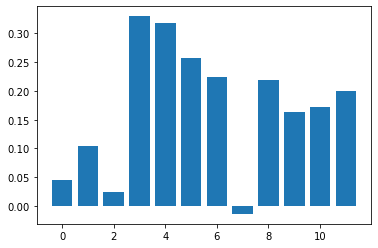

In [331]:

# linear regression feature importance
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot

# get importance
importance = LR.coef_
# summarize feature importance
for i,v in enumerate(importance[0]):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance[0]))], importance[0])
pyplot.show()

### Removed relative_humidity and p_slope(pressure slope) after getting negative score.

In [ ]:
import wandb
wandb.init(project="visualize-sklearn")

In [311]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
reg = Ridge()
reg.fit(X, y)
y_pred = reg.predict(x_test)

In [316]:
wandb.sklearn.plot_regressor(reg, x_train, x_test, y_train, y_test, 'Ridge')


wandb: 
wandb: Plotting Ridge.
wandb: Logged summary metrics.
wandb: Logged learning curve.
wandb: Logged outlier candidates.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: Logged residuals.


In [317]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(X, y)
y_pred = clf.predict(x_test)

In [320]:
wandb.sklearn.plot_learning_curve(clf, X, y)

In [326]:
wandb.sklearn.plot_feature_importances(LR, X.columns.array)